# **1. Import Libraries**

In [1]:
import cv2
import os
import random
import smtplib
import numpy as np
import tarfile
import tkinter as tk
from tkinter import *
from tkinter import ttk
from tkinter.ttk import *
import sqlite3
import csv
import os
import uuid
import tensorflow as tf

In [2]:
#Import Tensorflow  dependencies - Functional API
#Import metric calculations

from email.message import EmailMessage
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall
from tkinter import messagebox
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [3]:
#Avoid OOM Errors by setting GPU Memory Consumption Growth

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
#Setup Paths

POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
paths = [POS_PATH, NEG_PATH, ANC_PATH]

for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
# Path to your tar.gz file and the extraction directory
tar_file_path = 'lfw.tgz'
extraction_dir = 'lfw'

# Check if the extraction directory already exists
if not os.path.exists(extraction_dir):
    print("Extracting lfw.tgz...")
    with tarfile.open(tar_file_path, 'r:gz') as tar:
        tar.extractall(extraction_dir)
    print("Extraction completed.")
else:
    print("Extraction already done.")

Extraction already done.


In [7]:
#Move LFW Images to the following repository data/negative

source_directory = 'lfw'
destination_directory = NEG_PATH

# Check if transfer is already done
if not os.listdir(destination_directory):
    for directory in os.listdir(source_directory):
        for file in os.listdir(os.path.join(source_directory, directory)):
            EX_PATH = os.path.join(source_directory, directory, file)
            NEW_PATH = os.path.join(destination_directory, file)
            os.replace(EX_PATH, NEW_PATH)
    print("Transfer completed.")
else:
    print("Transfer is already done.")

Transfer is already done.


In [8]:
anchor = tf.data.Dataset.list_files(ANC_PATH+ '\*jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+ '\*jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+ '\*jpg').take(300)

In [9]:
dir_test = anchor.as_numpy_iterator()

In [10]:
def preprocess(file_path):
    
    #Read in image from File Path
    byte_img = tf.io.read_file(file_path)
    
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    #Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    
    #Scale the image to be between 0 and 1
    img = img / 255.0
    
    #Return the image
    return img

In [11]:
img = preprocess('data\\anchor\\b410402d-4354-11ef-b45e-dc1ba1d2de57.jpg')

In [12]:
positives = tf.data.Dataset.zip(anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))
negatives = tf.data.Dataset.zip(anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))
data = positives.concatenate(negatives)

In [13]:
samples = data.as_numpy_iterator()

In [14]:
example = samples.next()

In [15]:
example

(b'data\\anchor\\9d206389-47ed-11ef-8fc0-dc1ba1d2de57.jpg',
 b'data\\positive\\75876f9d-47ed-11ef-8294-dc1ba1d2de57.jpg',
 1.0)

In [16]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [17]:
res = preprocess_twin(*example)

In [18]:
#Build dataloader pipeline

data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [19]:
#Training Partition

train_data = data.take(round(len(data)*7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [20]:
train_samples = train_data.as_numpy_iterator()

In [21]:
train_sample = train_samples.next()

In [22]:
#Testing Partition

test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [23]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')
    
    #First block
    c1 = Conv2D(64,(10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    #Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    #Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    #Final Block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [24]:
embedding = make_embedding()

In [25]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Siamese L1 Distance class
class L1Dist(tf.keras.layers.Layer):
    
    # Init Method - inheritance
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__()
        
    #Similarity Calculation
    def call(self, input_embedding, validation_embedding):
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        
        return tf.math.abs(input_embedding - validation_embedding)
    
    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [27]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [28]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [29]:
siamese_layer = L1Dist()

In [30]:
distances = siamese_layer(inp_embedding, val_embedding)

In [31]:
classifier = Dense(1, activation='sigmoid')(distances)

In [32]:
# Define the Siamese model
def make_siamese_model():
    # Inputs
    input_image = Input(name='input_img', shape=(100, 100, 3))
    validation_image = Input(name='validation_img', shape=(100, 100, 3))

    # Generate embeddings
    inp_embedding = embedding(input_image)
    val_embedding = embedding(validation_image)

    # Create and call the L1 Distance layer
    siamese_layer = L1Dist(name='L1_Dist')
    distances = siamese_layer(inp_embedding, val_embedding)

    # Classification Layer
    classifier = Dense(1, activation='sigmoid', name='classifier')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [33]:
# Create the Siamese model
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (None, 4096)              │               0 │ embedding[2][0],           │
│                               │                           │                 │ embedding[3][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier (Dense)            │ (None, 1)                 │           4,097 │ l1_dist_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [35]:
opt = tf.keras.optimizers.Adam(1e-4) #0.0001

In [36]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint=tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [37]:
test_batch = train_data.as_numpy_iterator()

In [38]:
batch_1 = test_batch.next()

In [39]:
X = batch_1[:2]

In [40]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [41]:
@tf.function
def train_step(batch):
    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get Label
        y = batch[2]
        
        # Forward Pass
        yhat = siamese_model(X, training=True)
        # Squeeze yhat to remove extra dimensions
        yhat = tf.squeeze(yhat, axis=[0, -1])
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
        print(loss)
        
    # Calculate gradients 
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [42]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save Checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

# **2. Training Siamese Model**

In [43]:
model_file_path = 'siamese_model.h5'

def train_model():
    EPOCHS = 50
    train(train_data, EPOCHS)
    siamese_model.save(model_file_path)
    
if os.path.exists(model_file_path):
    print("Loading pre-trained model...")
    siamese_model = load_model(model_file_path, custom_objects={'L1Dist': L1Dist})
else:
    print("Model not found. Training a new model...")
train_model()

Loading pre-trained model...



 Epoch 1/50
Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
37/38 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/stepTensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
38/38 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step

 Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step

 Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step

 Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step

 Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step

 Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step

 Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step

 Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step

 Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step

 Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step

 Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step

 Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step

 Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step

 Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 200s 5s/step

 Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━

In [44]:
#Get a batch of test data

test_input,test_val, y_true = test_data.as_numpy_iterator().next()

In [45]:
#Make Predictions

y_hat = siamese_model.predict([test_input,test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[[1.0000000e+00],
        [1.3020649e-13],
        [4.2982280e-14],
        [1.3486321e-16],
        [1.0000000e+00],
        [2.3203526e-14],
        [1.0000000e+00],
        [1.7141186e-14],
        [9.9998450e-01],
        [1.6550172e-14],
        [5.2010517e-15],
        [1.0000000e+00],
        [1.0000000e+00],
        [9.9985695e-01],
        [1.0000000e+00],
        [7.0834019e-11]]], dtype=float32)

In [46]:
# Post processing the results
predictions = [1 if prediction > 0.5 else 0 for prediction in y_hat.flatten()]
predictions

[1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]

In [47]:
y_true

array([1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0.],
      dtype=float32)

In [48]:
#Creating a metric object
m = Recall()

#Calculating the recall value
m.update_state(y_true, y_hat)

#Return Recall Result
m.result().numpy()

1.0

In [49]:
#Creating a metric object
m = Precision()

#Calculating the recall value
m.update_state(y_true, y_hat)

#Return Precision Result
m.result().numpy()

1.0

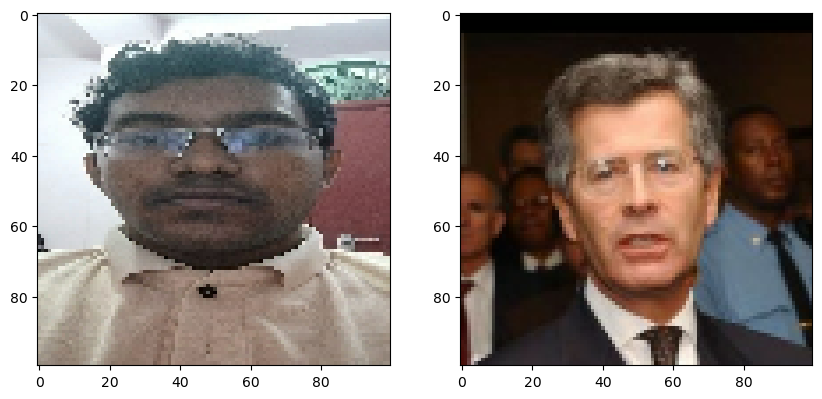

In [50]:
#Set plot size

plt.figure(figsize=(10,8))

#Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

#Set Second Subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

#Renders clearly
plt.show()

In [51]:
#Save Weights

siamese_model.save('siamesemodel.h5')

In [52]:
#Reload Model

model = tf.keras.models.load_model('siamesemodel.h5', 
                                  custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [53]:
#Make predictions with Reloaded Model

model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[[1.0000000e+00],
        [1.3020649e-13],
        [4.2982280e-14],
        [1.3486321e-16],
        [1.0000000e+00],
        [2.3203526e-14],
        [1.0000000e+00],
        [1.7141186e-14],
        [9.9998450e-01],
        [1.6550172e-14],
        [5.2010517e-15],
        [1.0000000e+00],
        [1.0000000e+00],
        [9.9985695e-01],
        [1.0000000e+00],
        [7.0834019e-11]]], dtype=float32)

In [54]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_3 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier (Dense)            │ (None, 1)                 │           4,097 │ l1_dist_3[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
os.listdir(os.path.join('application_data', 'verification_images'))

['64b0bc69-42b3-11ef-b7ee-dc1ba1d2de57.jpg',
 '64fbb364-42b3-11ef-a14d-dc1ba1d2de57.jpg',
 '652206fa-42b3-11ef-a985-dc1ba1d2de57.jpg',
 '654aef95-42b3-11ef-b432-dc1ba1d2de57.jpg',
 '69fb6023-42b3-11ef-a4ce-dc1ba1d2de57.jpg',
 'ae3df6fd-4354-11ef-addb-dc1ba1d2de57.jpg',
 'ae87a886-4354-11ef-93dd-dc1ba1d2de57.jpg',
 'aea8683e-4354-11ef-80bb-dc1ba1d2de57.jpg',
 'b06b0015-4354-11ef-9849-dc1ba1d2de57.jpg',
 'b13bb03c-4354-11ef-b599-dc1ba1d2de57.jpg',
 'b15c15df-4354-11ef-84b7-dc1ba1d2de57.jpg',
 'b20e0f6e-4354-11ef-a844-dc1ba1d2de57.jpg',
 'b25b03d6-4354-11ef-b970-dc1ba1d2de57.jpg',
 'b27b3549-4354-11ef-a04a-dc1ba1d2de57.jpg',
 'b2c54d33-4354-11ef-8ad1-dc1ba1d2de57.jpg',
 'b2e92634-4354-11ef-9e4a-dc1ba1d2de57.jpg',
 'b30a8caa-4354-11ef-bef8-dc1ba1d2de57.jpg',
 'b3c027f9-4354-11ef-bea1-dc1ba1d2de57.jpg',
 'b6c0c04b-4354-11ef-88ef-dc1ba1d2de57.jpg',
 'b6e1476d-4354-11ef-b62f-dc1ba1d2de57.jpg',
 'f3fc105a-4354-11ef-9742-dc1ba1d2de57.jpg',
 'f4279b30-4354-11ef-a142-dc1ba1d2de57.jpg',
 'f4a0384a

In [56]:
def verify(frame, model, detection_threshold, verification_threshold):
    #Build Results Array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_images', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images',image))
        
        #Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    #Detection Threshold: Metric above which a prediction is considered positive

    detection = np.sum(np.array(results) > detection_threshold)

    #Verification Threshold: Proportion of Positive Predictions / Total Positive Samples
    verification = detection/len(os.listdir(os.path.join('application_data','verification_images')))
    verified = verification > verification_threshold

    return results, verified

In [57]:
# Preprocessing function
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    return img

In [58]:
def start_video():
    main_video_path = 'face.mp4'
    negative_video_path = 'negative.mp4'
    current_video_path = main_video_path
    cap = cv2.VideoCapture(current_video_path)
    paused = False
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        cv2.namedWindow('Verification', cv2.WINDOW_NORMAL)
        cv2.resizeWindow('Verification', frame_width, frame_height)
        cv2.imshow('Verification', frame)
        key = cv2.waitKey(10) & 0xFF
        if key == ord('v'):
            cv2.imwrite(os.path.join('application_data', 'input_images', 'input_image.jpg'), frame)
            results, verified = verify(frame, siamese_model, 0.5, 0.5)
            if verified:
                messagebox.showinfo("Verification", "Verification Successful!")
                return True
            else:
                messagebox.showerror("Verification", "Invalid User or External User. Login Unsuccessful.")
                return False
        elif key == ord('n'):
            # Switch between the main video and the negative video
            cap.release()
            if current_video_path == main_video_path:
                current_video_path = negative_video_path
            else:
                current_video_path = main_video_path
            cap = cv2.VideoCapture(current_video_path)
        elif key == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            return None  # Indicate that the user quit the process
    cap.release()
    cv2.destroyAllWindows()
    return False

# **3. Setting up Tkinter Window**

In [59]:
root = Tk()
# Width and Height
w = 500
h = 650

# Background Color
bgcolor = '#bdc3c7'

# **4. Setup Database Connection**

In [60]:
def setup_database():
    conn = sqlite3.connect('bank_details.db')
    c = conn.cursor()
    c.execute('''DROP TABLE IF EXISTS bank''')
    c.execute('''CREATE TABLE bank (
                 id INTEGER PRIMARY KEY,
                 account_number VARCHAR(255) NOT NULL,
                 name TEXT NOT NULL,
                 pin TEXT NOT NULL,
                 email TEXT,
                 gender TEXT)''')
    conn.commit()
    conn.close()

setup_database()

# **5. Verify PIN**

In [61]:
#Verify Pin

def verify_pin(account_number, entered_pin):
    # Check the database
    conn = sqlite3.connect('bank_details.db')
    c = conn.cursor()
    c.execute("SELECT pin FROM bank WHERE account_number=?", (account_number,))
    db_pin = c.fetchone()
    conn.close()

    # Check the CSV file
    csv_pin = None
    if os.path.exists('bank_details.csv'):
        with open('bank_details.csv', 'r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                if row['account_number'] == account_number:
                    csv_pin = row['pin']
                    break

    return db_pin and db_pin[0] == entered_pin and csv_pin == entered_pin

# **6. OTP Verification**

In [62]:
#OTP Verification

def verify_otp(email):
    otp = random.randint(100000, 999999)  # Generate a 6-digit OTP
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()

    FROM_MAIL = 'vishnusr023@gmail.com'
    server.login(FROM_MAIL, 'fsla olcu ifnc pdyp')

    TO_MAIL = email

    msg = EmailMessage()
    msg['Subject'] = 'Bank OTP Verification'
    msg['From'] = FROM_MAIL
    msg['To'] = TO_MAIL
    msg.set_content(f'Your OTP is {otp}')

    server.send_message(msg)
    print("OTP sent successfully")
    return str(otp)

In [63]:
#Checking the OTP

def check_otp(correct_otp, entered_otp):
    return correct_otp == entered_otp

# **7. Setting Up Tkinter Window**

## **7.1. Header Section**

In [64]:
#Center Form

root.overrideredirect(1)
ws = root.winfo_screenwidth()
hs = root.winfo_screenheight()

In [65]:
x = (ws - w) / 2
y = (hs - h) / 2
root.geometry("%dx%d+%d+%d" % (w, h, x, y))

''

## **7.2. Tkinter Window**

In [68]:
#Setting up a Tkinter Window  

headerframe = tk.Frame(root, highlightbackground="yellow", highlightcolor='yellow', highlightthickness=2, bg="black", width=w, height=70)
titleframe = tk.Frame(headerframe, bg='yellow', highlightcolor='yellow', highlightthickness=2,)
title_label = tk.Label(titleframe, text="Bank Register", padx=20, pady=5, bg='green', fg='#fff', font=('Tahoma', 24), width=18)
close_button = tk.Button(headerframe, text="x", borderwidth=1, relief='solid', font=('Verdana', 12), bg="red", fg="white", command=close_win)

In [69]:
headerframe.pack()
titleframe.pack()
title_label.pack()

titleframe.place(rely=0.5, relx=0.5, anchor=CENTER)
close_button.place(x=460, y=10)

In [67]:
# Close window
def close_win():
    root.destroy()


In [70]:
#End Header Section

mainframe = tk.Frame(root, width=w, height=h)

# **8. Login Page**

In [71]:
loginframe = tk.Frame(mainframe, width=w, height=h)
login_contentframe = tk.Frame(loginframe, padx=30, pady=50, highlightbackground="yellow", highlightcolor='yellow', highlightthickness=2, bg=bgcolor)

accountnumber_label = tk.Label(login_contentframe, text="Account Number:", font=('Verdana', 16), bg=bgcolor)
cardholdername_label = tk.Label(login_contentframe, text="Name:", font=('Verdana', 16), bg=bgcolor)

accountnumber_entry = tk.Entry(login_contentframe, font=('Verdana', 16))
cardholdername_entry = tk.Entry(login_contentframe, font=('Verdana', 16))

enter_button = tk.Button(login_contentframe, text="Enter Your Account", font=('Verdana', 16), bg='#2980b9', fg='#fff', padx=10, width=25, command=lambda: login(accountnumber_entry.get(), cardholdername_entry.get()))

go_register_label = tk.Label(login_contentframe, text=">> don't have an account? create new one ", font=('Verdana', 12), bg=bgcolor, fg='red')

mainframe.pack(fill='both', expand=1)
login_contentframe.pack(fill='both', expand=1)

accountnumber_label.grid(row=0, column=0, pady=10, sticky='e')
accountnumber_entry.grid(row=0, column=1, pady=10, padx=5)

cardholdername_label.grid(row=1, column=0, pady=10, sticky='e')
cardholdername_entry.grid(row=1, column=1, pady=10, padx=5)

enter_button.grid(row=2, column=0, columnspan=2, pady=40)
go_register_label.grid(row=3, column=0, columnspan=2, pady=20)

In [72]:
#Function to display register function

def go_to_register():
    if loginframe.winfo_exists():
        loginframe.pack_forget()
    registerframe.pack(fill="both", expand=1)
    title_label["text"] = 'Register Your Account'
    title_label['bg'] = 'green'

go_register_label.bind("<Button-1>", lambda page: go_to_register())

'2312411209664<lambda>'

# **9. Register Page**

In [73]:
registerframe = tk.Frame(mainframe, width=w, height=h)
register_contentframe = tk.Frame(registerframe, padx=15, pady=15, highlightbackground="yellow", highlightcolor='yellow', highlightthickness=2, bg=bgcolor)

account_number_label_rg = tk.Label(register_contentframe, text="Account Number: ", font=('Verdana', 16), bg=bgcolor)
name_label_rg = tk.Label(register_contentframe, text="Name: ", font=('Verdana', 16), bg=bgcolor)
pin_label_rg = tk.Label(register_contentframe, text="Pin: ", font=('Verdana', 16), bg=bgcolor)
confirm_pin_label_rg = tk.Label(register_contentframe, text="Confirm Pin: ", font=('Verdana', 16), bg=bgcolor)
email_label_rg = tk.Label(register_contentframe, text="E-Mail: ", font=('Verdana', 16), bg=bgcolor)
gender_label_rg = tk.Label(register_contentframe, text="Gender: ", font=('Verdana', 16), bg=bgcolor)

account_number_entry_rg = tk.Entry(register_contentframe, font=('Verdana', 14), width=22)
name_entry_rg = tk.Entry(register_contentframe, font=('Verdana', 14), width=22)
pin_entry_rg = tk.Entry(register_contentframe, font=('Verdana', 14), width=22, show="*")
confirm_pin_entry_rg = tk.Entry(register_contentframe, font=('Verdana', 14), width=22, show="*")
email_entry_rg = tk.Entry(register_contentframe, font=('Verdana', 14), width=22)

radiosframe = tk.Frame(register_contentframe)
gender_var = StringVar()
male_radiobutton = tk.Radiobutton(radiosframe, text="Male", font=("Verdana", 14), bg=bgcolor, variable=gender_var, value="Male")
female_radiobutton = tk.Radiobutton(radiosframe, text="Female", font=("Verdana", 14), bg=bgcolor, variable=gender_var, value="Female")

register_button = tk.Button(register_contentframe, text="Register", font=('Verdana', 16), bg='#2980b9', fg='#fff', padx=10, width=25, command=lambda: register(
    account_number_entry_rg.get(),
    name_entry_rg.get(),
    pin_entry_rg.get(),
    confirm_pin_entry_rg.get(),
    email_entry_rg.get(),
    gender_var.get()
))

go_login_label = tk.Label(register_contentframe, text=">> already have an account? Sign In ", font=('Verdana', 12), bg=bgcolor, fg='red')

registerframe.pack(fill='both', expand=1)
register_contentframe.pack(fill='both', expand=1)

account_number_label_rg.grid(row=0, column=0, pady=5, sticky='e')
account_number_entry_rg.grid(row=0, column=1, pady=5)

name_label_rg.grid(row=1, column=0, pady=5, sticky='e')
name_entry_rg.grid(row=1, column=1)

pin_label_rg.grid(row=2, column=0, pady=5, sticky='e')
pin_entry_rg.grid(row=2, column=1)

confirm_pin_label_rg.grid(row=3, column=0, pady=5, sticky='e')
confirm_pin_entry_rg.grid(row=3, column=1)

email_label_rg.grid(row=4, column=0, pady=5, sticky='e')
email_entry_rg.grid(row=4, column=1)

gender_label_rg.grid(row=5, column=0, pady=5, sticky='e')
radiosframe.grid(row=5, column=1)
male_radiobutton.grid(row=0, column=0)
female_radiobutton.grid(row=0, column=1)

register_button.grid(row=6, column=0, columnspan=2, pady=20)

go_login_label.grid(row=7, column=0, columnspan=2, pady=10)

In [74]:
#Function to display a login function

def go_to_login():
    if registerframe.winfo_exists():
        registerframe.pack_forget()
    loginframe.pack(fill="both", expand=1)
    title_label["text"] = 'Login'
    title_label['bg'] = 'blue'

go_login_label.bind("<Button-1>", lambda page: go_to_login())

'2312411276736<lambda>'

## **10. Setting Up Registration Function**

In [75]:
def register(account_number, name, pin, confirm_pin, email, gender):
    if pin != confirm_pin:
        print("Pin and Confirm Pin do not match")
        return

    conn = sqlite3.connect('bank_details.db')
    c = conn.cursor()
    c.execute("SELECT * FROM bank WHERE account_number=?", (account_number,))
    if c.fetchone():
        print("Account already exists")
    else:
        c.execute("INSERT INTO bank (account_number, name, pin, email, gender) VALUES (?, ?, ?, ?, ?)",
                  (account_number, name, pin, email, gender))
        conn.commit()
        print("User registered successfully")
        export_to_csv()  
    conn.close()

# **11. Setting Up Login Function**

In [76]:
# Function to login an existing user
def login(account_number, name):
    # Check the database
    conn = sqlite3.connect('bank_details.db')
    c = conn.cursor()
    c.execute("SELECT * FROM bank WHERE account_number=? AND name=?", (account_number, name))
    db_user = c.fetchone()
    conn.close()

    # Check the CSV file
    csv_user = None
    if os.path.exists('bank_details.csv'):
        with open('bank_details.csv', 'r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                if row['account_number'] == account_number and row['name'] == name:
                    csv_user = row
                    break

    if db_user or csv_user:
        verification_result = start_video()
        if verification_result is None:
            print("Video verification was cancelled.")
        elif verification_result:
            entered_pin = input("Enter your PIN: ")
            if verify_pin(account_number, entered_pin):
                user_email = db_user[4] if db_user else csv_user['email']
                correct_otp = verify_otp(user_email)
                entered_otp = input("Enter the OTP sent to your email: ")
                if check_otp(correct_otp, entered_otp):
                    print("Login Successful!")
                else:
                    print("Invalid OTP. Login Unsuccessful")
            else:
                print("Invalid PIN. Login Unsuccessful")
        else:
            print("Face Verification failed. Login unsuccessful")
    else:
        print("Invalid Account Number or Name")

In [77]:
# Function to export data to CSV
def export_to_csv():
    conn = sqlite3.connect('bank_details.db')
    c = conn.cursor()
    c.execute("SELECT * FROM bank")
    rows = c.fetchall()
    with open('bank_details.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['id', 'account_number', 'name', 'pin', 'email', 'gender'])
        writer.writerows(rows)
    conn.close()
    print("Data exported to bank_details.csv")

In [78]:
# Start with the login frame

root.mainloop()

User registered successfully
Data exported to bank_details.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━